In [23]:
import os
import cv2
import json
import random
import easyocr
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap
random.seed(1)

In [5]:
IMG_PATH = os.getenv('TVQA_IMG_PATH')
VAL_JSON = os.getenv('TVQA_VAL_JSON')

baseline_pred = '../snap/textvqa_m4c_28662719/reports/textvqa_run_val_2021-02-28T16:21:14.json'

In [68]:
def display_img(pred_im_path, ocr_results, notes='ocr'):
    im = cv2.imread(pred_im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)

    for res in ocr_results:
        bbox = res['bbox']
        txt = res['txt']
        plt.gca().add_patch(
            plt.Rectangle((bbox[0][0], bbox[0][1]),
                          bbox[1][0] - bbox[0][0],
                          bbox[1][1] - bbox[0][1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.5)
                )
        plt.gca().text(bbox[0][0], bbox[0][1] - 5,
                    '%s' % (txt),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=15, color='white')
    plt.gca().text(20,50, notes,
                    bbox=dict(facecolor='blue', alpha=0.9),
                    fontsize=30, color='white')

def post_process_ocr_results(results, sys=None):
    outputs = [] # a list of dicts with keys "bbox","txt" 
    if sys == 'easyocr':
        for res in results:
            output = {'txt':res[1], 'bbox':[res[0][0], res[0][2]]}
            outputs.append(output)
    else:
        raise NotImplementedError('not found {}'.format(sys))
    return outputs

def prepare_qid_info_map(tvqa_data):
    return {i['question_id']:i for i in tvqa_data['data']}

def check_ans(d, td):
    
    ans = d["answer"].replace(" 's'","'s'")
    s = set(td["answers"])
    if ans in s:
        return True
    return False

In [69]:
baseline_data = json.load(open(baseline_pred))
tvqa_val_data = json.load(open(VAL_JSON))
val_qid_info_map = prepare_qid_info_map(tvqa_val_data)

baseline_data = [x for x in baseline_data if not check_ans(x,val_qid_info_map[x["question_id"]])]

## setup all ocr readers

In [86]:
easyocr_reader = easyocr.Reader(['en'])
# paddleocr
# clova
# google


In [79]:
# randomly choose examples
#pred_info = random.choice(baseline_data)
pred_info = baseline_data[45]

In [84]:
pred_info

{'question_id': 38435,
 'image_id': '35aab56a08cd7413',
 'answer': 'cade',
 'pred_source': ['OCR']}

In [80]:
gt_info = val_qid_info_map[pred_info['question_id']]
pred_im_path = os.path.join(IMG_PATH, '{}.jpg'.format(gt_info['image_id']))

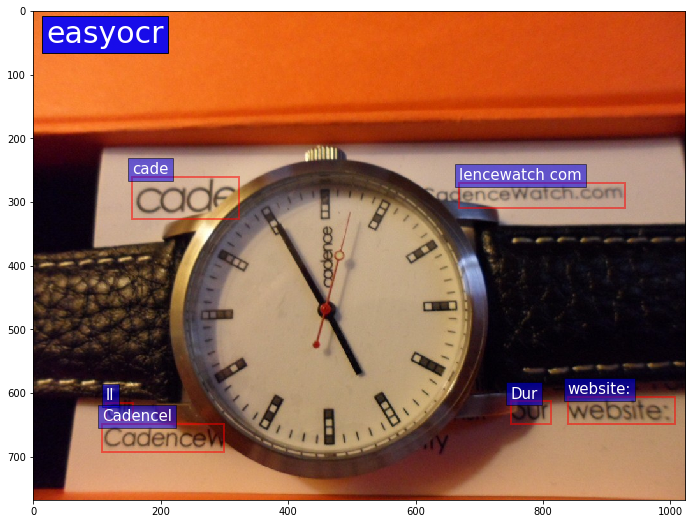

In [87]:
# easyocr
easyocr_results = easyocr_reader.readtext(pred_im_path)
easyocr_results = post_process_ocr_results(easyocr_results, sys='easyocr')
display_img(pred_im_path, easyocr_results, notes='easyocr')

In [3]:
!pip install --upgrade azure-cognitiveservices-vision-computervision


  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/f2/de/03ddaffabd541829394fb6ee4615f642ed1a14438b4543a01ad58f7d222e/azure_cognitiveservices_vision_computervision-0.7.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/19/2b/46ada1753c4a640bc3ad04a1e20b1a5ea52a8f18079e1b8238e536aa0c98/azure_common-1.1.26-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e8/cc/6c96bfb3d3cf4c3bdedfa6b46503223f4c2a4fa388377697e0f8082a4fed/msrest-0.6.21-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0f/45/0bbd380b5ff5802eb60598cc79777d21dbd04065fb703c145dc5a8d55b41/azure_cognitiveservices_vision_nspkg-3.0.1-py2-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c2/95/af354f2f415d250dafe26a5d94230558aa8cf733a9dcbf0d26cd61f5a9b8/azure_nspkg-3.0.2-py2-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/a0/5f06e1e1d463903cf0c0eebeb75179111

In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time
import const
import json

In [2]:
subscription_key = "OFCIWON'TTELLYOUGUYSTHIS"
endpoint = "https://textvqa.cognitiveservices.azure.com/"

In [3]:
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [4]:
print("===== Batch Read File - remote =====")
# Get an image with handwritten text
# remote_image_handw_text_url = "https://raw.githubusercontent.com/MicrosoftDocs/azure-docs/master/articles/cognitive-services/Computer-vision/Images/readsample.jpg"

# Call API with URL and raw response (allows you to get the operation location)
# recognize_handw_results = computervision_client.read(remote_image_handw_text_url,  raw=True)

def word2dic(w):
    ret = {}
    for att in w.__dict__.keys():
        ret[att] = w.__dict__[att]
    return ret

def line2dic(l):
    ret = {}
    for att in l.__dict__.keys():
        if att!="words":
            ret[att] = l.__dict__[att]
        else:
            ret["words"] = []
            for w in l.words:
                ret["words"].append(word2dic(w))
    return ret

def res2dic(res):
    ret = {}
    for att in res.__dict__.keys():
        if att!="lines":
            ret[att] = res.__dict__[att]
        else:
            ret["lines"] = []
            for l in res.lines:
                ret["lines"].append(line2dic(l))
    return ret  

for _,_,ls in os.walk(const.IMG_PATH):
    pred_ls = ls


===== Batch Read File - remote =====


In [ ]:
error_f = open("./azocr_fail_imgs.txt","w")
err_cnt = 0
for cnt, img in enumerate(pred_ls):
    print(cnt,len(pred_ls),err_cnt,img,end="\r")
    pred_im_path = os.path.join(const.IMG_PATH,img)
    recognize_handw_results = computervision_client.read_in_stream(open(pred_im_path, 'rb'),raw=True)

    # Get the operation location (URL with an ID at the end) from the response
    operation_location_remote = recognize_handw_results.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = operation_location_remote.split("/")[-1]

    # Call the "GET" API and wait for it to retrieve the results 
    while True:
        get_handw_text_results = computervision_client.get_read_result(operation_id)
        if get_handw_text_results.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    # Print the detected text, line by line
    if get_handw_text_results.status == OperationStatusCodes.succeeded:
        out_f = open(os.path.join(const.AZURE_OCR_PATH,img.split(".")[0]+".json"),"w")
        results = get_handw_text_results.analyze_result.read_results
        #print(len(results))
        json.dump(res2dic(get_handw_text_results.analyze_result.read_results[0]),out_f)
        out_f.close()
        #print(outstr)
        #print("SUCCEED!", img)
    else:
        #print("WRONG!", img)
        error_f.write(f"{cnt}\t{img}\n")
        err_cnt+=1

print()
print("DA CHENG GONG!")
error_f.close()
    

In [18]:
#print(get_handw_text_results.analyze_result.read_results[0].__dict__.items())
#print(get_handw_text_results.analyze_result.read_results[0].lines[0].words[0].__dict__.items())

dict_items([('additional_properties', {}), ('language', None), ('bounding_box', [607.0, 329.0, 852.0, 329.0, 852.0, 357.0, 607.0, 358.0]), ('text', 'NISSAN GENISS'), ('words', [<azure.cognitiveservices.vision.computervision.models._models_py3.Word object at 0x7fa383bf9128>, <azure.cognitiveservices.vision.computervision.models._models_py3.Word object at 0x7fa383bf9908>])])
